# Tagging geopoints with the Bogotá location and municipality.

With this notebook we are tagging the geopoints with the Bogotá district and minicipality. This is necesary for data preprocess for more human comprensive because these tag we can filter a cluster the locations.

Note: the data used in this project was take from https://bogota-laburbano.opendatasoft.com/pages/home/


In [1]:
# load librarys
import geopandas as gpd
import matplotlib.pyplot as plt
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Let’s first enable shapely.speedups which makes some of the spatial queries running faster.
import shapely.speedups
shapely.speedups.enable()

In [2]:
# File with geopints with commerces points 
data = gpd.read_file("data/establecimientos-comerciales-2016.kml", driver='KML')
data.head()

,Name,Description,geometry
0,328338,,POINT (-74.08504 4.74002)
1,304681,,POINT (-74.09650 4.74037)
2,328347,,POINT (-74.08505 4.54817)
3,304686,,POINT (-74.09651 4.59819)
4,328356,,POINT (-74.08502 4.66973)


In [3]:
# Filepath to KML file with location polygon (localidades)
polys = gpd.read_file("data/poligonos-localidades.kml", driver='KML')
polys.head()

,Name,Description,geometry
0,ANTONIO NARIÑO,,"MULTIPOLYGON (((-74.13075 4.59335, -74.13075 4..."
1,TEUSAQUILLO,,"MULTIPOLYGON (((-74.09372 4.66607, -74.10342 4..."
2,SUMAPAZ,,"MULTIPOLYGON (((-74.20584 4.26966, -74.20567 4..."
3,SAN CRISTOBAL,,"MULTIPOLYGON (((-74.02900 4.55830, -74.02892 4..."
4,USAQUEN,,"MULTIPOLYGON (((-74.01089 4.66358, -74.01077 4..."


In [4]:
    # Filepath to KML file with municipality polygon (municipio)
    municipalities = gpd.read_file("data/scat.kml", driver='KML')
    municipalities.head()

,Name,Description,geometry
0,CANAVERALEJO,,"MULTIPOLYGON (((-74.20388 4.64294, -74.20330 4..."
1,LAS PALMAS,,"MULTIPOLYGON (((-74.14915 4.16888, -74.14906 4..."
2,SAN BLAS II,,"MULTIPOLYGON (((-74.07788 4.56646, -74.07801 4..."
3,SAN BERNARDINO XXII URBANO,,"MULTIPOLYGON (((-74.21595 4.62411, -74.21551 4..."
4,LA PRADERA NORTE,,"MULTIPOLYGON (((-74.03735 4.73956, -74.03658 4..."


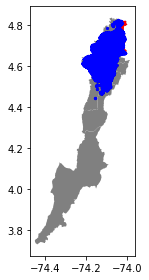

In [5]:
# Let’s select that one and see where it is located, and plot also the points on top of the map.
polygon = polys.loc[polys['Name']=='USAQUEN']
polygon.reset_index(drop=True, inplace=True)
fig, ax = plt.subplots()
polys.plot(ax=ax, facecolor='gray');
polygon.plot(ax=ax, facecolor='red');
data.plot(ax=ax, color='blue', markersize=5);
plt.tight_layout();

In [6]:
# Let’s check which Points are within the location Polygon. 
pip_mask = data.within(polygon.loc[0, 'geometry'])
print(pip_mask.head())
pip_mask.value_counts()

0    False
1    False
2    False
3    False
4    False
dtype: bool


False    410908
True      28979
dtype: int64

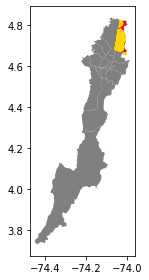

In [7]:
# Let’s finally confirm that our Point in Polygon query worked as it should by plotting the data.
pip_data = data.loc[pip_mask]
polygon = polys.loc[polys['Name']=='USAQUEN']
polygon.reset_index(drop=True, inplace=True)
fig, ax = plt.subplots()
polys.plot(ax=ax, facecolor='gray');
polygon.plot(ax=ax, facecolor='red');
pip_data.plot(ax=ax, color='gold', markersize=2);
plt.tight_layout();

In [8]:
# Fuction identification location 
def commerce_within(data, polys, column_name):
    locations = set(polys['Name'])
    #n = 0
    for l in locations:
        polygon = polys.loc[polys['Name']== l]
        polygon.reset_index(drop=True, inplace=True)
        pip_mask = data.within(polygon.loc[0, 'geometry'])
        data.loc[pip_mask.index,column_name] = l
    return data[column_name]

In [9]:
# Tag localidad
commerce_within(data, polys, 'localidad')

# Tag municipio
commerce_within(data, municipalities, 'municipio')

0         CIUDAD BOLIVAR
1         CIUDAD BOLIVAR
2         CIUDAD BOLIVAR
3         CIUDAD BOLIVAR
4         CIUDAD BOLIVAR
               ...      
439882    CIUDAD BOLIVAR
439883    CIUDAD BOLIVAR
439884    CIUDAD BOLIVAR
439885    CIUDAD BOLIVAR
439886    CIUDAD BOLIVAR
Name: municipio, Length: 439887, dtype: object

In [10]:
data.columns

Index(['Name', 'Description', 'geometry', 'localidad', 'municipio'], dtype='object')

In [11]:
data.head()

,Name,Description,geometry,localidad,municipio
0,328338,,POINT (-74.08504 4.74002),CIUDAD BOLIVAR,CIUDAD BOLIVAR
1,304681,,POINT (-74.09650 4.74037),CIUDAD BOLIVAR,CIUDAD BOLIVAR
2,328347,,POINT (-74.08505 4.54817),CIUDAD BOLIVAR,CIUDAD BOLIVAR
3,304686,,POINT (-74.09651 4.59819),CIUDAD BOLIVAR,CIUDAD BOLIVAR
4,328356,,POINT (-74.08502 4.66973),CIUDAD BOLIVAR,CIUDAD BOLIVAR


In [12]:
# Save data
data.to_file("output/comercios_etiquetados.geojson", driver='GeoJSON')